In [1]:
# Get bitcoin data from GeckoAPI
from pycoingecko import CoinGeckoAPI
from datetime import datetime 

import numpy as np
import pandas as pd

# API wrapper
cg = CoinGeckoAPI()

# Get previous prices (1 yr + 1 day)
data = cg.get_coin_market_chart_by_id(id='bitcoin', vs_currency='usd', days='366', interval='daily')
prices = data['prices']
total_vols = data['total_volumes']

df = pd.DataFrame()
df['Date'] = pd.DataFrame(prices)[0]
df['Price'] = pd.DataFrame(prices)[1]
df['Total_Vols'] = pd.DataFrame(total_vols)[1]
df

,Date,Price,Total_Vols
0,1592870400000,9678.683209,2.476862e+10
1,1592956800000,9624.684292,1.775680e+10
2,1593043200000,9288.061774,2.318376e+10
3,1593129600000,9258.667161,2.349918e+10
4,1593216000000,9166.486360,2.242920e+10
...,...,...,...
362,1624147200000,35581.642268,2.885898e+10
363,1624233600000,35787.077405,3.560913e+10
364,1624320000000,31711.935468,5.187387e+10
365,1624406400000,32507.738707,5.744301e+10


In [2]:
# Clean data format
# Unix timestamp -> utc format
df['Date'] = df['Date'].apply(lambda x: datetime.utcfromtimestamp(int(x) / 1000).strftime('%Y-%m-%d'))

# Show only 2 decimals (will not modify actual value)
pd.options.display.float_format = "{:,.2f}".format
df

,Date,Price,Total_Vols
0,2020-06-23,"9,678.68","24,768,621,256.84"
1,2020-06-24,"9,624.68","17,756,804,210.06"
2,2020-06-25,"9,288.06","23,183,760,291.75"
3,2020-06-26,"9,258.67","23,499,175,984.22"
4,2020-06-27,"9,166.49","22,429,204,010.64"
...,...,...,...
362,2021-06-20,"35,581.64","28,858,979,691.79"
363,2021-06-21,"35,787.08","35,609,127,163.62"
364,2021-06-22,"31,711.94","51,873,870,276.52"
365,2021-06-23,"32,507.74","57,443,014,757.92"


In [3]:
# Create new column indicating price change from previous day
df['Difference'] = df['Price'] - df['Price'].shift(periods = 1)

# Drop the 0th row (it has no previous data)
df = df.dropna()
df = df.reset_index(drop = True)

# Boolean value of whether price whent up.
# 0 change is considered 'up', since there will be no loss of profit.
df['Up'] = df['Difference'].apply(lambda x: True if x >= 0 else False)

df

,Date,Price,Total_Vols,Difference,Up
0,2020-06-24,"9,624.68","17,756,804,210.06",-54.00,False
1,2020-06-25,"9,288.06","23,183,760,291.75",-336.62,False
2,2020-06-26,"9,258.67","23,499,175,984.22",-29.39,False
3,2020-06-27,"9,166.49","22,429,204,010.64",-92.18,False
4,2020-06-28,"9,013.91","21,515,626,881.10",-152.58,False
...,...,...,...,...,...
361,2021-06-20,"35,581.64","28,858,979,691.79",-299.47,False
362,2021-06-21,"35,787.08","35,609,127,163.62",205.44,True
363,2021-06-22,"31,711.94","51,873,870,276.52","-4,075.14",False
364,2021-06-23,"32,507.74","57,443,014,757.92",795.80,True


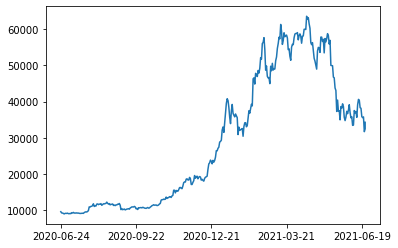

In [4]:
# Overview of price
import matplotlib.pyplot as plt

plt.plot(df['Date'], df['Price'])
plt.xticks(np.arange(0, len(df['Date']) - 1, 90))
plt.show()

In [5]:
# Create KNN algorithm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

X = df[['Price', 'Total_Vols', 'Difference']]
Y = df['Up']

# Split training and testing data
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, shuffle = True)

In [6]:
# Train KNN
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)

# Make prediction & measure accuracy in percentages
acc_train = accuracy_score(y_train, knn.predict(x_train)) * 100
acc_test = accuracy_score(y_test, knn.predict(x_test)) * 100

In [7]:
# Show model metrics
print(f'Training data accuracy : {acc_train:.2f} %')
print(f'Test data accuracy : {acc_test:.2f} %')

Training data accuracy : 69.14 %
Test data accuracy : 50.00 %
